In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import warnings

import re
import nltk
from wordcloud import WordCloud
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from sklearn.metrics import confusion_matrix,classification_report,accuracy_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import CountVectorizer

warnings.filterwarnings('ignore')
sns.set_style('darkgrid')
plt.rcParams['figure.figsize'] = (10, 6)

In [2]:
''' reading data '''
df = pd.read_csv('amazon_alexa.tsv', delimiter='\t')

In [3]:
''' displaying first 5 rows '''
df.head()

,rating,date,variation,verified_reviews,feedback
0,5,31-Jul-18,Charcoal Fabric,Love my Echo!,1
1,5,31-Jul-18,Charcoal Fabric,Loved it!,1
2,4,31-Jul-18,Walnut Finish,"Sometimes while playing a game, you can answer...",1
3,5,31-Jul-18,Charcoal Fabric,I have had a lot of fun with this thing. My 4 ...,1
4,5,31-Jul-18,Charcoal Fabric,Music,1


In [4]:
''' checking null values '''
df.isnull().sum()

rating              0
date                0
variation           0
verified_reviews    1
feedback            0
dtype: int64

In [5]:
''' checking info of data '''
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3150 entries, 0 to 3149
Data columns (total 5 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   rating            3150 non-null   int64 
 1   date              3150 non-null   object
 2   variation         3150 non-null   object
 3   verified_reviews  3149 non-null   object
 4   feedback          3150 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 123.2+ KB


In [6]:
df['verified_reviews'].fillna(0, inplace=True)

variation
Black  Dot                      516
Charcoal Fabric                 430
Configuration: Fire TV Stick    350
Black  Plus                     270
Black  Show                     265
Name: count, dtype: int64


Text(0.5, 1.0, 'Top 5 Variation')

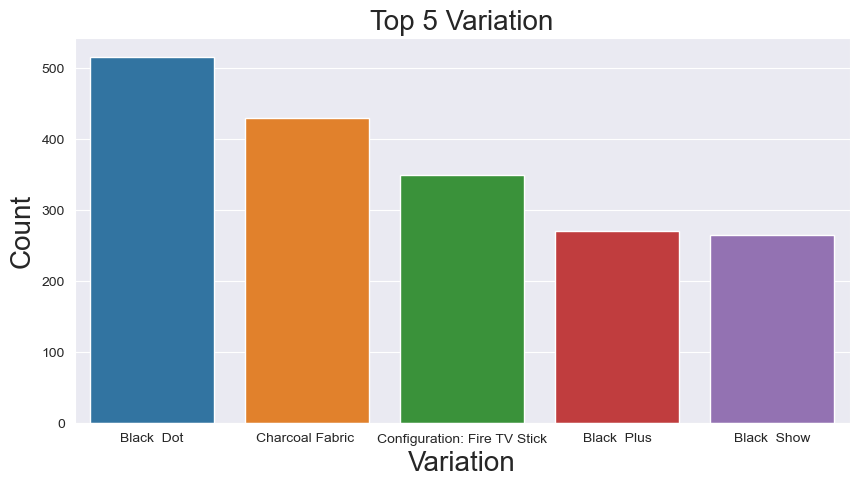

In [7]:
''' value counts of variation '''
variation_label = df.variation.value_counts()[:5]
print(variation_label)

''' plotting top 5 variation '''
plt.figure(figsize=(10, 5))
sns.barplot(x=variation_label.index, y=variation_label)
plt.xlabel('Variation', fontsize=20)
plt.ylabel('Count', fontsize=20)
plt.title('Top 5 Variation', fontsize=20)

In [8]:
''' shape of data '''
df.shape

(3150, 5)

In [9]:
''' adding a len column for analyzing the length of the reviews '''
df['verified_reviews'] = df['verified_reviews'].astype(str)

# Add a new column 'len' to analyze the length of reviews
df['len'] = df['verified_reviews'].map(len)

# Display the 'len' column
df['len']

0        13
1         9
2       195
3       172
4         5
       ... 
3145     50
3146    135
3147    441
3148    380
3149      4
Name: len, Length: 3150, dtype: int64

In [10]:
''' displaying data based on len '''
df.groupby('len').describe().sample(10)

rating                                               feedback            \
      count      mean       std  min   25%  50%  75%  max    count      mean   
len                                                                            
205     8.0  3.750000  1.752549  1.0  3.25  4.5  5.0  5.0      8.0  0.750000   
901     1.0  2.000000       NaN  2.0  2.00  2.0  2.0  2.0      1.0  0.000000   
1124    1.0  1.000000       NaN  1.0  1.00  1.0  1.0  1.0      1.0  0.000000   
115     3.0  4.333333  0.577350  4.0  4.00  4.0  4.5  5.0      3.0  1.000000   
24     23.0  4.565217  0.727767  2.0  4.00  5.0  5.0  5.0     23.0  0.956522   
338     4.0  3.500000  1.732051  2.0  2.00  3.5  5.0  5.0      4.0  0.500000   
720     1.0  1.000000       NaN  1.0  1.00  1.0  1.0  1.0      1.0  0.000000   
108    10.0  4.400000  1.264911  1.0  4.25  5.0  5.0  5.0     10.0  0.900000   
258     1.0  4.000000       NaN  4.0  4.00  4.0  4.0  4.0      1.0  1.000000   
823     1.0  5.000000       NaN  5.0  5.00  5.0  5.0  5.0      1.0  1.000000   

                                          
           std  min   25%  50%  75%  max  
len                                       
205   0.462910  0.0  0.75  1.0  1.0  1.0  
901        NaN  0.0  0.00  0.0  0.0  0.0  
1124       NaN  0.0  0.00  0.0  0.0  0.0  
115   0.000000  1.0  1.00  1.0  1.0  1.0  
24    0.208514  0.0  1.00  1.0  1.0  1.0  
338   0.577350  0.0  0.00  0.5  1.0  1.0  
720        NaN  0.0  0.00  0.0  0.0  0.0  
108   0.316228  0.0  1.00  1.0  1.0  1.0  
258        NaN  1.0  1.00  1.0  1.0  1.0  
823        NaN  1.0  1.00  1.0  1.0  1.0

In [11]:
'''displaying the data according to the Ratings '''
df.groupby('rating').describe()

feedback                                        len              \
          count mean  std  min  25%  50%  75%  max   count        mean   
rating                                                                   
1         161.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   161.0  195.000000   
2          96.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0    96.0  249.156250   
3         152.0  1.0  0.0  1.0  1.0  1.0  1.0  1.0   152.0  207.296053   
4         455.0  1.0  0.0  1.0  1.0  1.0  1.0  1.0   455.0  178.520879   
5        2286.0  1.0  0.0  1.0  1.0  1.0  1.0  1.0  2286.0  108.444007   

                                                       
               std  min    25%    50%     75%     max  
rating                                                 
1       212.371226  1.0  36.00  120.0  284.00  1124.0  
2       269.624196  1.0  78.75  163.0  309.25  1686.0  
3       272.194706  1.0  54.00  130.0  284.00  1954.0  
4       215.927849  1.0  34.00   99.0  241.00  1360.0  
5       152.116387  1.0  26.00   64.0  135.00  2851.0

In [12]:
'''displaying the data according to the Ratings '''
df.groupby('feedback').describe()

rating                                                  len  \
           count      mean       std  min  25%  50%  75%  max   count   
feedback                                                                
0          257.0  1.373541  0.484688  1.0  1.0  1.0  2.0  2.0   257.0   
1         2893.0  4.737643  0.546544  3.0  5.0  5.0  5.0  5.0  2893.0   

                                                                   
                mean         std  min   25%    50%    75%     max  
feedback                                                           
0         215.229572  236.336504  1.0  53.0  137.0  289.0  1686.0  
1         124.659177  174.624491  1.0  29.0   69.0  154.0  2851.0

rating
5    2286
4     455
1     161
3     152
2      96
Name: count, dtype: int64


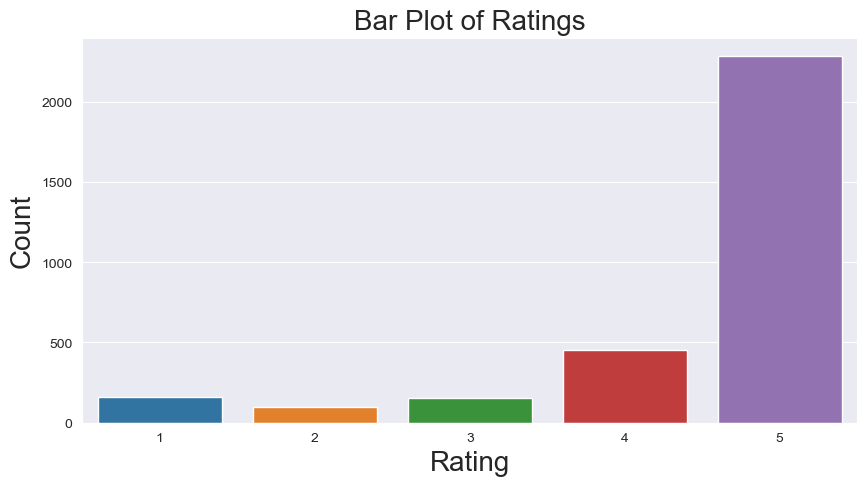

In [13]:
''' visualization '''


''' value counts of rating '''
rating_label = df.rating.value_counts()
print(rating_label)

''' barplot '''
plt.figure(figsize=(10, 5))
sns.barplot(x=rating_label.index, y=rating_label);
plt.xlabel('Rating', fontsize=20)
plt.ylabel('Count', fontsize=20);
plt.title('Bar Plot of Ratings', fontsize=20);

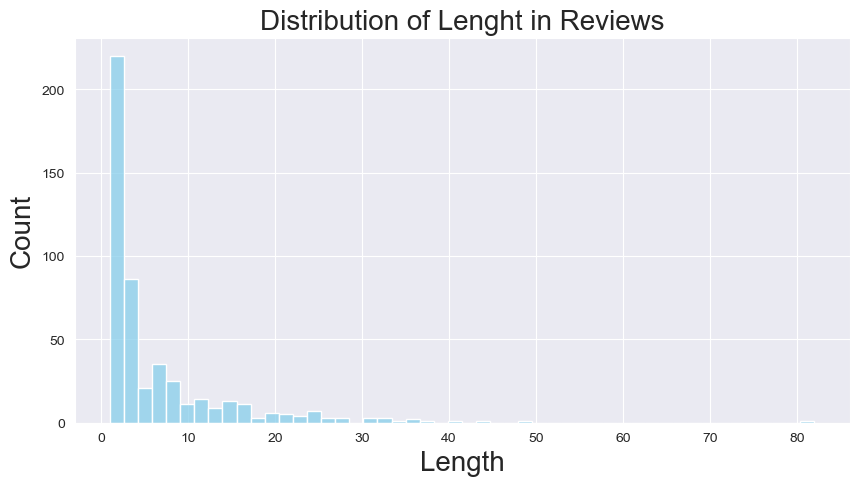

In [14]:
''' histogram plot of len of reivews '''
len_label = df.len.value_counts()
plt.figure(figsize=(10, 5))
sns.histplot(len_label, bins=50, color='skyblue');
plt.xlabel('Length', fontsize=20)
plt.ylabel('Count', fontsize=20);
plt.title('Distribution of Lenght in Reviews', fontsize=20);

In [15]:
''' Let's Check some of the reviews according to thier lengths '''
df[df.len == 1]['verified_reviews'].iloc[0]

'😍'

In [16]:
df[df['len'] == 150]['verified_reviews'].iloc[0]

"Got this on Amazon prime with the ring pro. Work really great. Being the lazy guy I am I don't need to go see who at my door anymore while I'm gaming."

In [17]:
df[df['len'] == 50]['verified_reviews'].iloc[0]

'Yet another Exho for our home and love them all!!!'

In [18]:
df[df.len == 25]['verified_reviews'].iloc[0]

'I love it, wife hates it.'

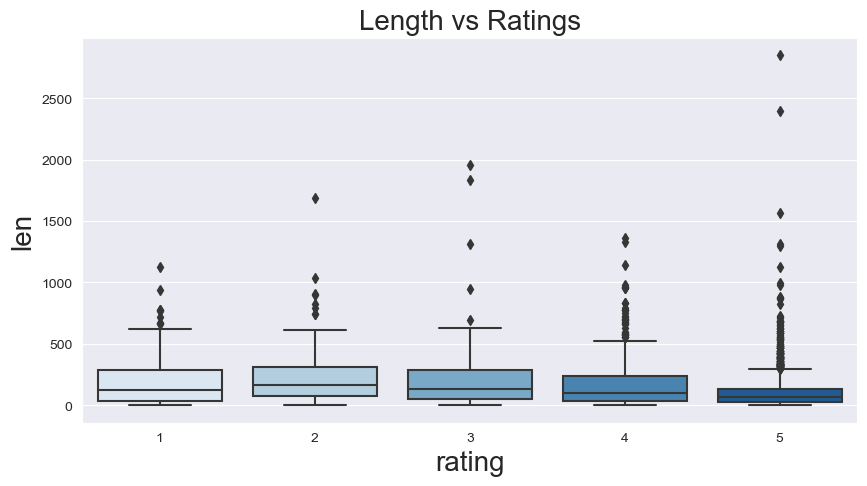

In [19]:
''' box plot '''
plt.figure(figsize=(10, 5))
sns.boxplot(x=df.rating, y=df.len, palette = 'Blues')
plt.title("Length vs Ratings", fontsize=20)
plt.xlabel('rating', fontsize=20)
plt.ylabel('len', fontsize=20);

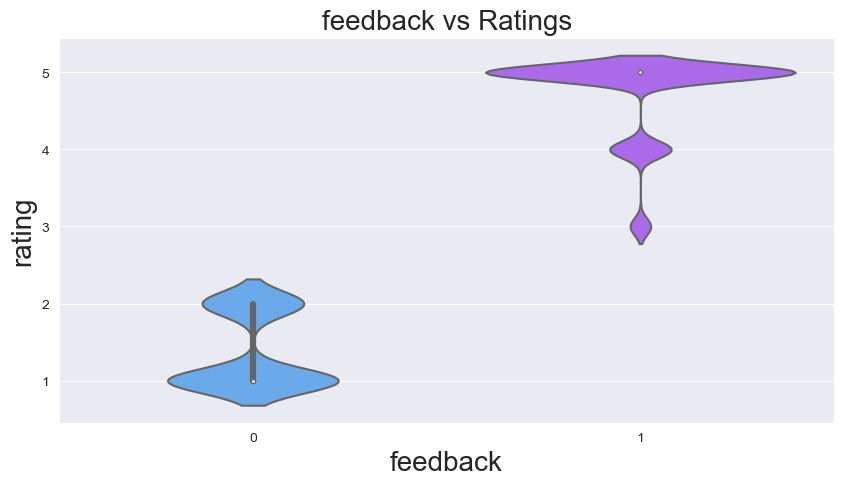

In [20]:
''' violin plot '''
plt.figure(figsize=(10, 5))
sns.violinplot(x=df['feedback'], y=df['rating'], palette = 'cool')
plt.title("feedback vs Ratings", fontsize=20)
plt.xlabel('feedback', fontsize=20)
plt.ylabel('rating', fontsize=20);

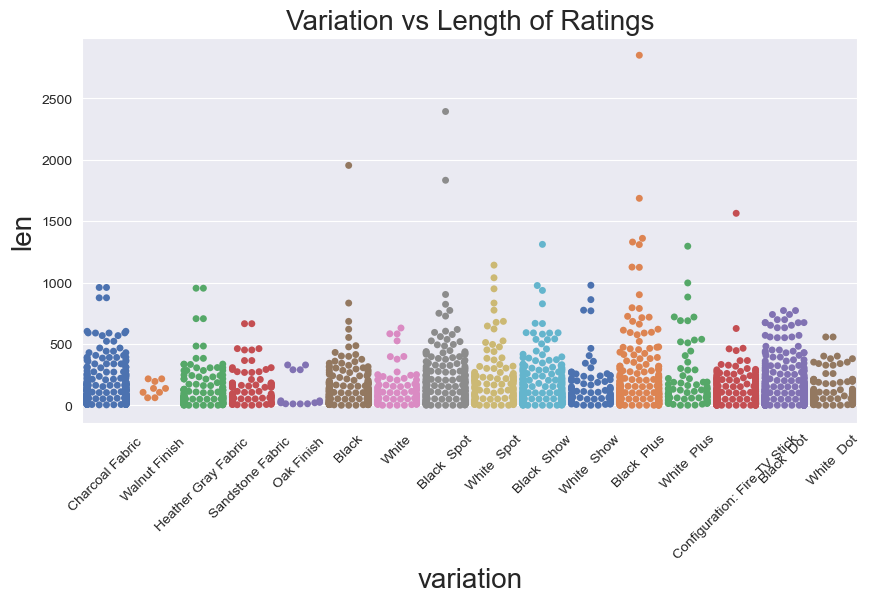

In [21]:
''' swarmplot '''
plt.figure(figsize=(10, 5))
sns.swarmplot(x=df['variation'], y=df['len'], palette = 'deep')
plt.title("Variation vs Length of Ratings", fontsize=20)
plt.xticks(rotation = 45);
plt.xlabel('variation', fontsize=20)
plt.ylabel('len', fontsize=20);

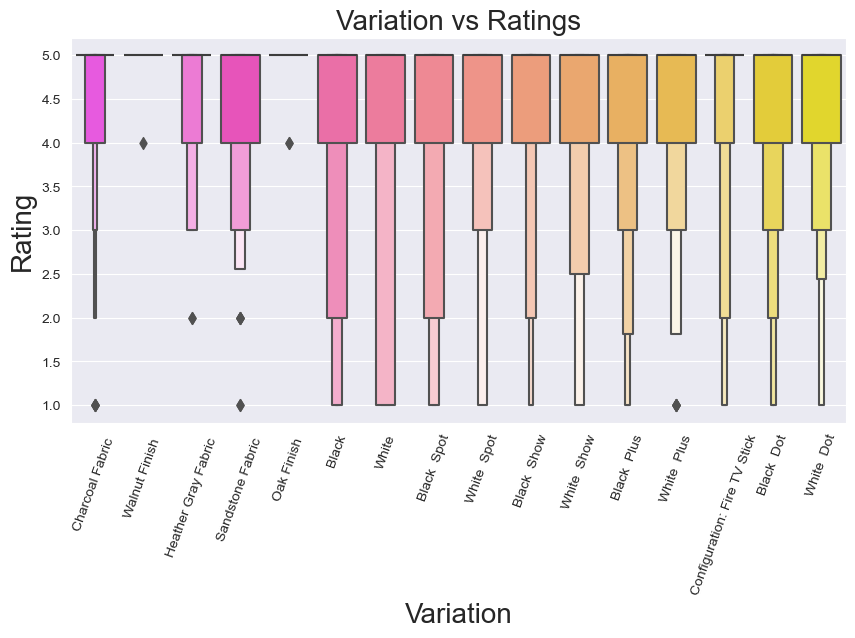

In [22]:
''' bivariate analysis '''
plt.figure(figsize=(10, 5))
sns.boxenplot(x=df['variation'],y= df['rating'], palette = 'spring')
plt.title("Variation vs Ratings", fontsize=20)
plt.xticks(rotation = 70);
plt.xlabel('Variation', fontsize=20)
plt.ylabel('Rating', fontsize=20);

In [23]:
''' preprocessing of text '''

''' CountVectorrizer '''
count_vector = CountVectorizer(stop_words='english') 

ws = count_vector.fit_transform(df.verified_reviews)
s_w = ws.sum(axis=0)
w_f = [(w, s_w[0, idx]) for w, idx in count_vector.vocabulary_.items()]
w_f = sorted(w_f, key = lambda x: x[1], reverse = True)

''' creating dataframe '''
freq = pd.DataFrame(w_f, columns=['word', 'freq'])

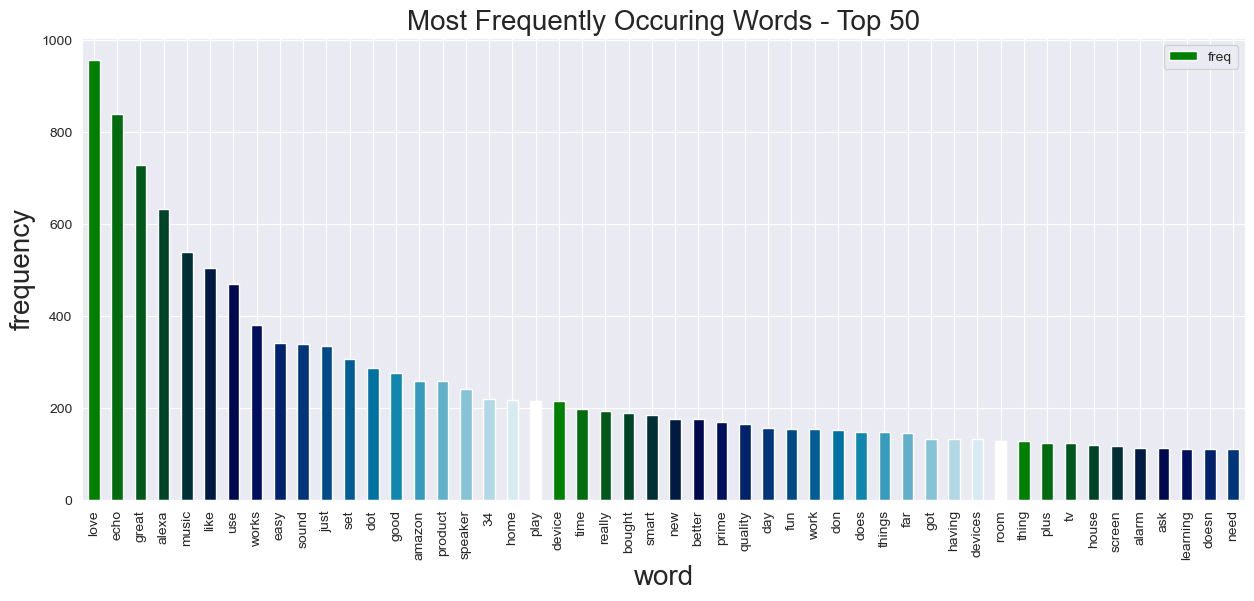

In [24]:
''' barplot of top 50 frequently occuring words '''
color = plt.cm.ocean(np.linspace(0, 1, 20))
freq.head(50).plot(x='word', y='freq', kind='bar', figsize=(15, 6), color = color)
plt.title("Most Frequently Occuring Words - Top 50", fontsize=20)
plt.xlabel('word', fontsize=20)
plt.ylabel('frequency', fontsize=20);

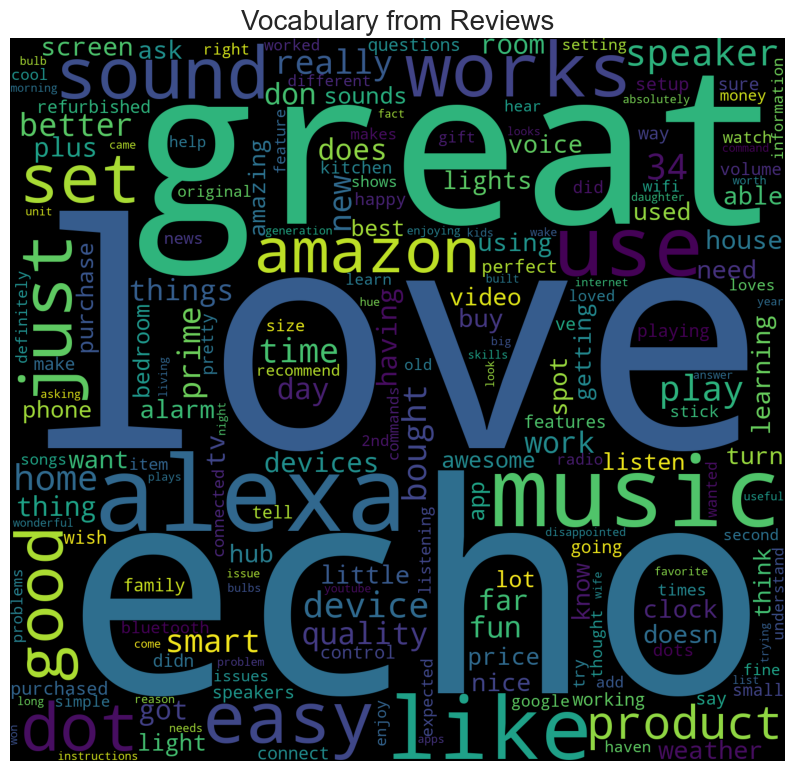

In [25]:
''' representing words on WordCloud '''
word_cloud = WordCloud(background_color='black', width=1500, height=1400).generate_from_frequencies(dict(w_f))
plt.figure(figsize=(10, 10))
plt.axis('off')
plt.imshow(word_cloud)
plt.title("Vocabulary from Reviews", fontsize = 20);

In [26]:
''' preproecessing '''
c = []

for i in range(0, 3150):
    ''' removing characters except a-z and A-Z'''
    r = re.sub('[^a-zA-Z]', ' ', df['verified_reviews'][i])
    ''' converting every word into lower word'''
    r = r.lower()
    ''' splitting text '''
    r = r.split()
    ''' apllying Stemming '''
    ps = PorterStemmer()
    ''' removing stopwords '''
    sw = stopwords.words('english')
    sw.remove('not')
    r = [ps.stem(word) for word in r if not word in set(sw)]
    r = ' '.join(r)
    c.append(r)

In [27]:
''' count vectorizer '''
count_vector = CountVectorizer(max_features=2500) 

''' independent and dependent variables '''
x = count_vector.fit_transform(c).toarray()
y = df.iloc[:, 4].values

''' checking shape '''
print(x.shape)
print(y.shape)

(3150, 2500)
(3150,)


In [28]:
''' train test split '''
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.25, random_state=42)

In [40]:
print("shape of X_train: ", y_train.shape)
print("shape of X_test: ", x_test.shape)

shape of X_train:  (2362,)
shape of X_test:  (788, 2500)


In [41]:
''' Min Max Scaler '''
min_max_sc = MinMaxScaler()

x_train = min_max_sc.fit_transform(x_train)
x_test = min_max_sc.transform(x_test)

In [42]:
x_train

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

Classifiation report :               precision    recall  f1-score   support

           0       0.83      0.41      0.55        73
           1       0.94      0.99      0.97       715

    accuracy                           0.94       788
   macro avg       0.89      0.70      0.76       788
weighted avg       0.93      0.94      0.93       788

Accuracy : 0.9378172588832487


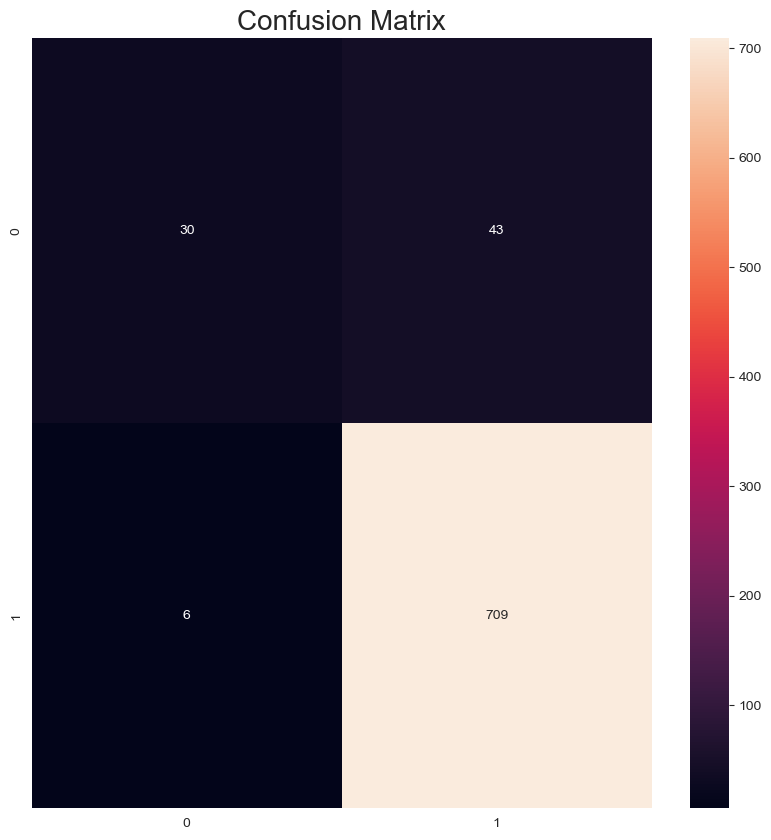

In [31]:
''' Random Forest Classifier '''
rf = RandomForestClassifier()

''' fit on data '''
rf.fit(x_train, y_train)

''' prediction '''
y_pred = rf.predict(x_test)

''' confusion matrix '''
plt.figure(figsize=(10, 10))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='g');
plt.title('Confusion Matrix', fontsize=20);
print('Classifiation report :', classification_report(y_test, y_pred))
print('Accuracy :',accuracy_score(y_test, y_pred))

In [44]:
''' Hyperparameter Tunning '''

p = {
    'bootstrap': [True],
    'max_depth': [80, 100],
    'min_samples_split': [8, 12],
    'n_estimators': [100, 300]
}

''' Grid Search CV '''
grid_cv = GridSearchCV(estimator=rf, param_grid=p, cv=10, verbose=0, scoring='accuracy', n_jobs=-1, 
                       return_train_score=True)
grid_cv.fit(x_train, y_train)

GridSearchCV(cv=10, estimator=RandomForestClassifier(), n_jobs=-1,
             param_grid={'bootstrap': [True], 'max_depth': [80, 100],
                         'min_samples_split': [8, 12],
                         'n_estimators': [100, 300]},
             return_train_score=True, scoring='accuracy')

In [46]:
print("Best Parameter : {}".format(grid_cv.best_params_))

Best Parameter : {'bootstrap': True, 'max_depth': 80, 'min_samples_split': 8, 'n_estimators': 300}


In [48]:
rf_cv = RandomForestClassifier(bootstrap=True, max_depth=80, min_samples_split=8, n_estimators=300)

''' fit on data '''
rf_cv.fit(x_train, y_train)

''' prediction '''
pred = rf_cv.predict(x_test)

Classifiation report :               precision    recall  f1-score   support

           0       0.83      0.41      0.55        73
           1       0.94      0.99      0.97       715

    accuracy                           0.94       788
   macro avg       0.89      0.70      0.76       788
weighted avg       0.93      0.94      0.93       788

Accuracy : 0.9378172588832487


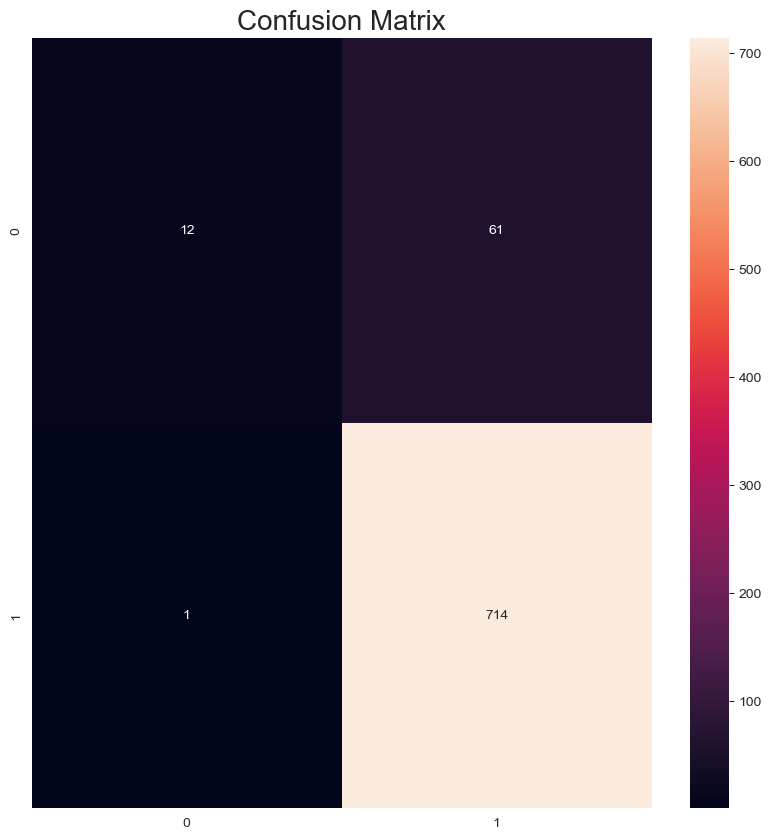

In [49]:
''' confusion matrix '''
plt.figure(figsize=(10, 10))
sns.heatmap(confusion_matrix(y_test, pred), annot=True, fmt='g')
plt.title('Confusion Matrix', fontsize=20)
print('Classifiation report :', classification_report(y_test, y_pred))
print('Accuracy :',accuracy_score(y_test, y_pred))